## Common imports

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

## Test images download

In [ ]:
!gsutil cp gs://cv-examples/* .

# Example of image understanding
Example of image understanding that computer vision can help with

## Image understanding with pypi libs

In [ ]:
!pip3 install --upgrade pixellib
!pip3 install pycocotools
!pip3 install --upgrade Pillow
!pip install google-cloud-vision --upgrade

Download model from the latest release

In [ ]:
!wget https://github.com/ayoolaolafenwa/PixelLib/releases/download/0.2.0/pointrend_resnet50.pkl

Show image for a test

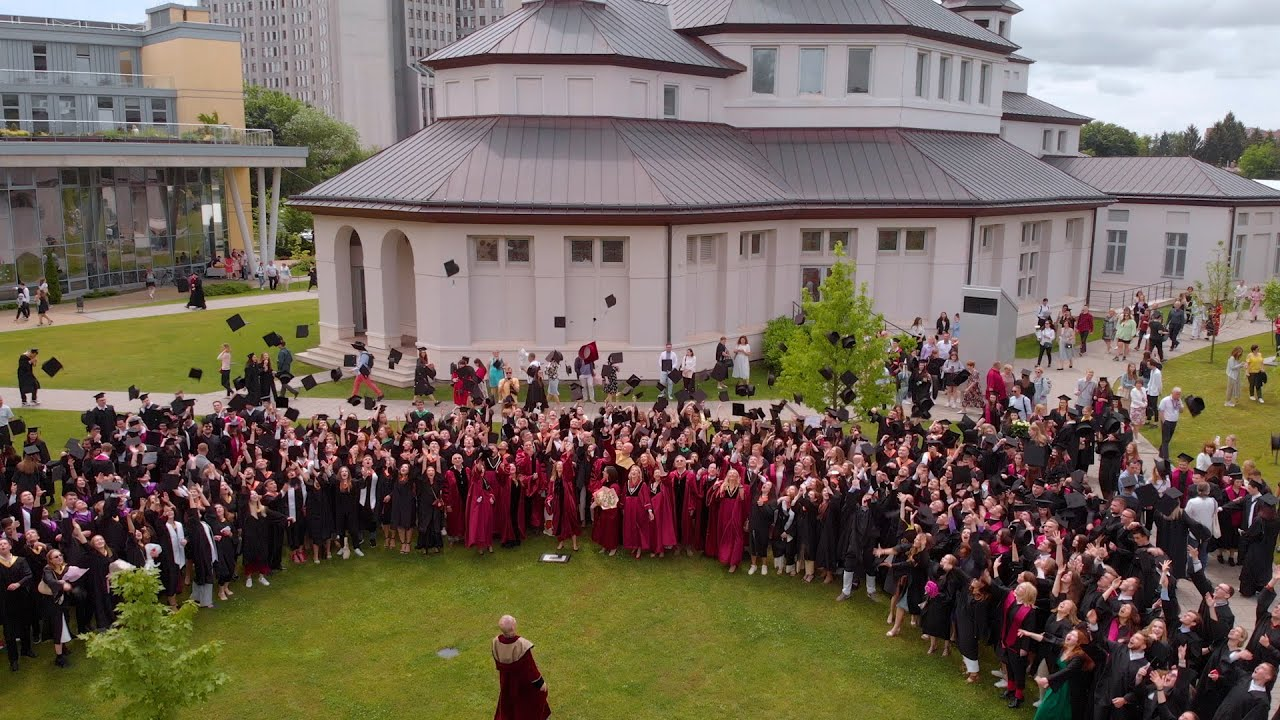

In [6]:
img = cv2.imread("graduation.jpeg")
cv2_imshow(img)

In [ ]:
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

ins = instanceSegmentation()
ins.load_model("pointrend_resnet50.pkl")
info = ins.segmentImage("graduation.jpeg", show_bboxes=True, output_image_name="output_graduation.jpeg")
print(set(info[0]["class_names"]))

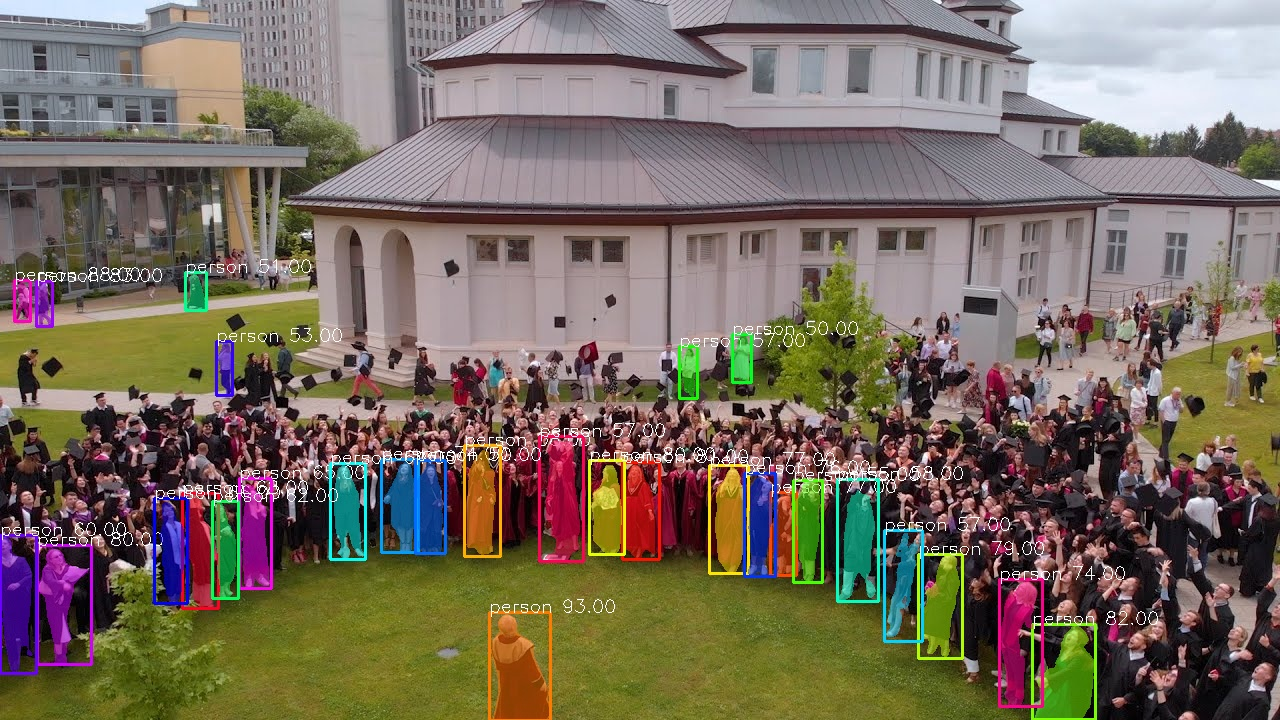

In [8]:
img = cv2.imread("output_graduation.jpeg")
cv2_imshow(img)

## Google Cloud Vision

### Installation

In [ ]:
!pip install google-cloud-vision --upgrade

### Service account creation
Create service account within the project

In [10]:
from google.cloud import vision
from google.oauth2 import service_account

key_path = "input_key_path.json"

credentials = service_account.Credentials.from_service_account_file(key_path)
client = vision.ImageAnnotatorClient(credentials=credentials)


### Detect labels
For more check official [tutorial](https://cloud.google.com/vision/docs/labels)

In [11]:
from google.cloud import vision
import io

client = vision.ImageAnnotatorClient(credentials=credentials)
with io.open("graduation.jpeg", 'rb') as image_file:
    content = image_file.read()
image = vision.Image(content=content)
response = client.label_detection(image=image)

labels = response.label_annotations
print('Labels:')

# Iterate over the labels and print them
for label in labels:
    print(label.description, label.score)

Labels:
Building 0.9147213697433472
Public space 0.8231940865516663
Social group 0.8221846222877502
Community 0.812167227268219
Crowd 0.81036376953125
Window 0.7723832726478577
Leisure 0.7648576498031616
Pole 0.7517053484916687
Event 0.7503365874290466
Uniform 0.7449193596839905


### Detect logos

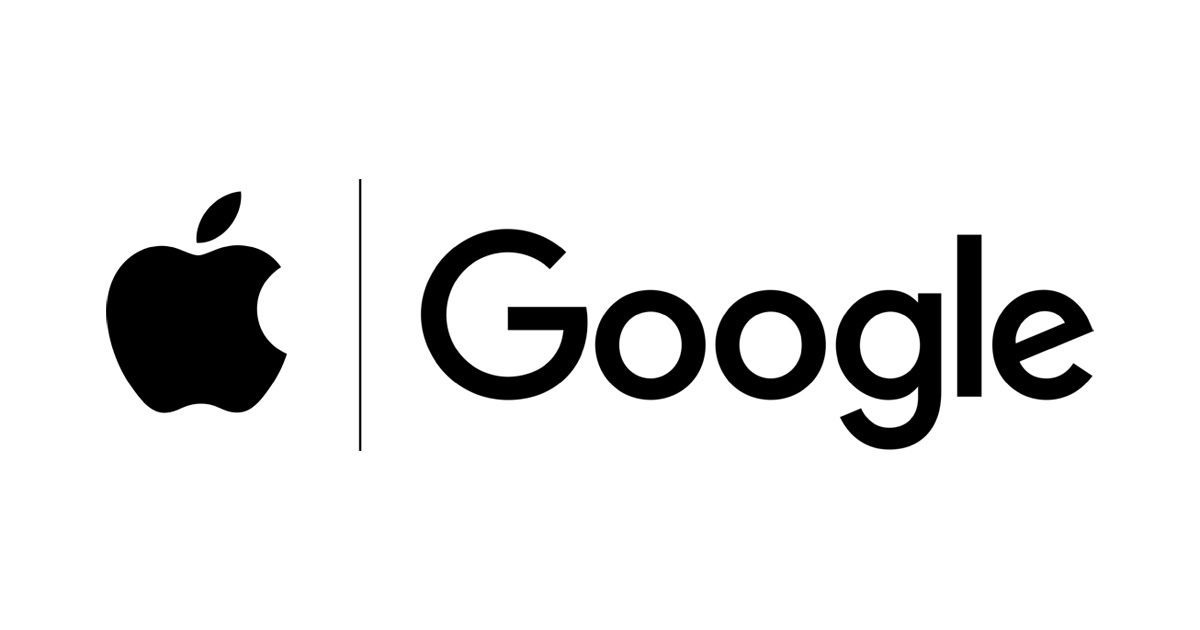

In [12]:
img = cv2.imread("logos.jpg")
cv2_imshow(img)

In [13]:
from google.cloud import vision
import io
client = vision.ImageAnnotatorClient(credentials=credentials)

with io.open("logos.jpg", "rb") as image_file:
    content = image_file.read()

image = vision.Image(content=content)

response = client.logo_detection(image=image)
logos = response.logo_annotations
print('Logos:')

for logo in logos:
    print(logo.description)

Logos:
Apple Inc.
Google


### Detect landmarks
For more check official [tutorial](https://cloud.google.com/vision/docs/detecting-landmarks)

In [14]:
from google.cloud import vision
import io
client = vision.ImageAnnotatorClient(credentials=credentials)

with io.open("graduation.jpeg", 'rb') as image_file:
    content = image_file.read()

image = vision.Image(content=content)

response = client.landmark_detection(image=image)
landmarks = response.landmark_annotations
print('Landmarks:')
for landmark in landmarks:
    print(landmark.description)



Landmarks:
Trapezna Ucu


### [TODO] OCR text

1.   Use Google OCR to recognize text. Output raw text
2.   Rotate input image based on information that you received from Google OCR


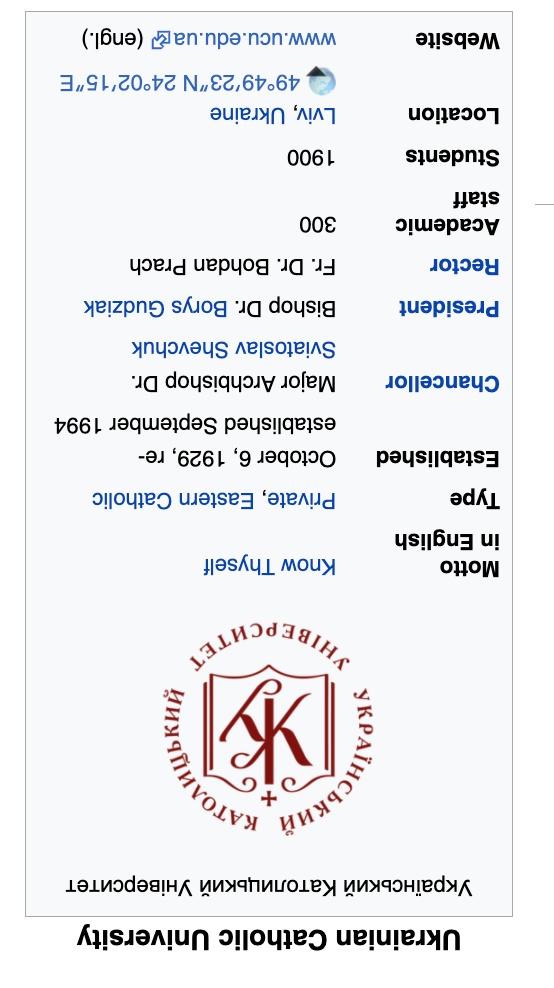

In [15]:
img = cv2.imread("wiki.png")
cv2_imshow(img)

I tried to make an output with all of the words stored as they are listed in the rows

for this I need row_threshold, which I manually adjusted to get an acceptable splitting

In [16]:
from google.cloud import vision
import io
import os
from PIL import Image

client = vision.ImageAnnotatorClient(credentials=credentials)

with io.open("wiki.png", "rb") as image_file:
    content = image_file.read()

image = vision.Image(content=content)
response = client.text_detection(image=image)

texts = response.text_annotations

row_threshold = 38
rows = {}

for text in texts[1:]:
    vertices = text.bounding_poly.vertices
    top_left_vertex = vertices[0]
    y_coord = top_left_vertex.y
    found_row = False
    for row in rows:
        if abs(row - y_coord) <= row_threshold:
            rows[row].append(text.description)
            found_row = True
            break
    if not found_row:
        rows[y_coord] = [text.description]


for row in sorted(rows.keys()):
    print("-- " + ' '.join(rows[row]))


-- Website www.ucu.edu.ua ( engl . )
-- Location Lviv , Ukraine 49 ° 49′23 ″ N 24 ° 02′15 ″ E
-- Students 1900
-- Academic staff 300
-- Rector Fr. Dr. Bohdan Prach
-- President Bishop Dr. Borys Gudziak
-- Chancellor Major Archbishop Dr. Sviatoslav Shevchuk
-- Established October 6 , 1929 , re established September 1994
-- Type Private , Eastern Catholic
-- Motto in English Know Thyself
-- [ ]
-- OHIKE КАТОЛИЦЬКИЙ КАТОЛИЦЬКИЙ
-- Український Католицький Університет
-- Ukrainian Catholic University


Now I check if the picture is in natural orientation, or not

I do this by cheching all words and detecting thir orientation and then asigning the most frequent value as rotation angle

In [17]:
import numpy as np
import math

def calculate_angle(vertices):
    top_left, top_right = vertices[0], vertices[1]
    angle_radians = math.atan2(top_right.y - top_left.y, top_right.x - top_left.x)
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

def categorize_orientation(angle):
    if -45 <= angle <= 45:
        return 0
    elif 45 < angle <= 135:
        return 90
    elif (135 < angle <= 180) or (-180 <= angle < -135):
        return 180
    elif -135 <= angle < -45:
        return 270

orientation_list = []
for text in texts:
    vertices = text.bounding_poly.vertices
    angle = calculate_angle(vertices)
    orientation = categorize_orientation(angle)
    orientation_list.append(orientation)
    print(f"Text: {text.description}, Orientation: {orientation} degrees")


Text: Ukrainian Catholic University
Український Католицький Університет
Motto
in English
Type
Established
Chancellor
President
Rector
Academic
staff
Students
Location
Website
OHIKE
[]
Know Thyself
КАТОЛИЦЬКИЙ
КАТОЛИЦЬКИЙ
Private, Eastern Catholic
October 6, 1929, re-
established September 1994
Major Archbishop Dr.
Sviatoslav Shevchuk
1900
Lviv, Ukraine
Bishop Dr. Borys Gudziak
Fr. Dr. Bohdan Prach
300
49°49′23″N 24°02′15″E
www.ucu.edu.ua (engl.), Orientation: 0 degrees
Text: Ukrainian, Orientation: 180 degrees
Text: Catholic, Orientation: 180 degrees
Text: University, Orientation: 180 degrees
Text: Український, Orientation: 180 degrees
Text: Католицький, Orientation: 180 degrees
Text: Університет, Orientation: 180 degrees
Text: Motto, Orientation: 180 degrees
Text: in, Orientation: 180 degrees
Text: English, Orientation: 180 degrees
Text: Type, Orientation: 180 degrees
Text: Established, Orientation: 180 degrees
Text: Chancellor, Orientation: 180 degrees
Text: President, Orientation: 1

In [18]:
from collections import Counter

def most_frequent(lst):
    counter = Counter(lst)
    most_common_element, count = counter.most_common(1)[0]
    return most_common_element

orient_freq = most_frequent(orientation_list)
print(orient_freq)

180


I have the orientation ange, so I can rotate the picture:

In [19]:
from PIL import Image

def rotate_image(input_path, output_path, degrees_to_rotate):
    with Image.open(input_path) as img:
        rotated_img = img.rotate(degrees_to_rotate, expand=True)
        rotated_img.save(output_path, quality=95)

rotate_image("wiki.png","wiki_rotated.png", 180)

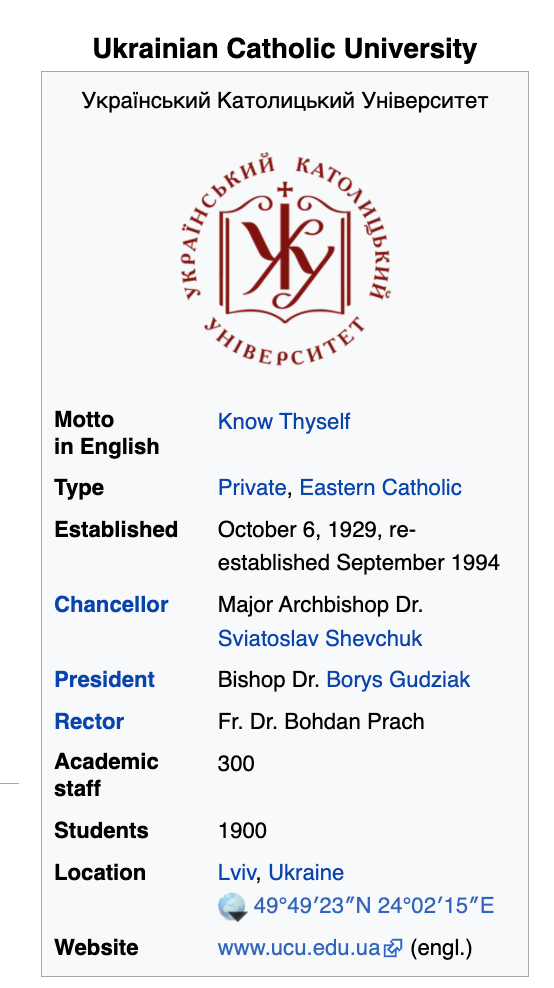

In [20]:
cv2_imshow(cv2.imread("wiki_rotated.png"))

Also, that means, that now rows will be stores in opposite way:

In [21]:
if orient_freq == 180:
  list_of_rows = sorted(rows.keys())[::-1]
else:
  list_of_wors = sorted(rows.keys())
for row in list_of_rows:
  print("-- " + ' '.join(rows[row]))


-- Ukrainian Catholic University
-- Український Католицький Університет
-- OHIKE КАТОЛИЦЬКИЙ КАТОЛИЦЬКИЙ
-- [ ]
-- Motto in English Know Thyself
-- Type Private , Eastern Catholic
-- Established October 6 , 1929 , re established September 1994
-- Chancellor Major Archbishop Dr. Sviatoslav Shevchuk
-- President Bishop Dr. Borys Gudziak
-- Rector Fr. Dr. Bohdan Prach
-- Academic staff 300
-- Students 1900
-- Location Lviv , Ukraine 49 ° 49′23 ″ N 24 ° 02′15 ″ E
-- Website www.ucu.edu.ua ( engl . )


# NumPy

Let write convolution (linear filter) from scratch
Nice [visualization](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

In [22]:
img = cv2.imread("graduation.jpeg", cv2.IMREAD_GRAYSCALE)

In [23]:
def convolve_2D(img, kernel, padding=0, strides=1):
    """
    2D convolution
    """
    x_kernel_shape = kernel.shape[0]
    y_kernel_shape = kernel.shape[1]
    x_img_shape = img.shape[0]
    y_img_shape = img.shape[1]

    # Shape of Output Convolution
    x_output_shape = int(((x_img_shape - x_kernel_shape + 2 * padding) / strides) + 1)
    y_output_shape = int(((y_img_shape - y_kernel_shape + 2 * padding) / strides) + 1)
    output = np.zeros((x_output_shape, y_output_shape))

    # Apply Equal Padding to All Sides
    if padding != 0:
        image_padded = np.zeros((img.shape[0] + padding*2, img.shape[1] + padding*2))
        image_padded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = img
    else:
        image_padded = img

    # Iterate through image
    for y in range(img.shape[1]):
        # Exit Convolution
        if y > img.shape[1] - y_kernel_shape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(img.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > img.shape[0] - x_kernel_shape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * image_padded[x:x+x_kernel_shape, y:y+y_kernel_shape]).sum()
                except:
                    break

    return output

In [24]:
def gaussian_kernel(size=5, sigma=1):
    """
    Creates Gaussian kernel with side length `sizw` and a sigma of `sigma`
    """
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss) # https://numpy.org/doc/stable/reference/generated/numpy.outer.html
    return kernel / np.sum(kernel)

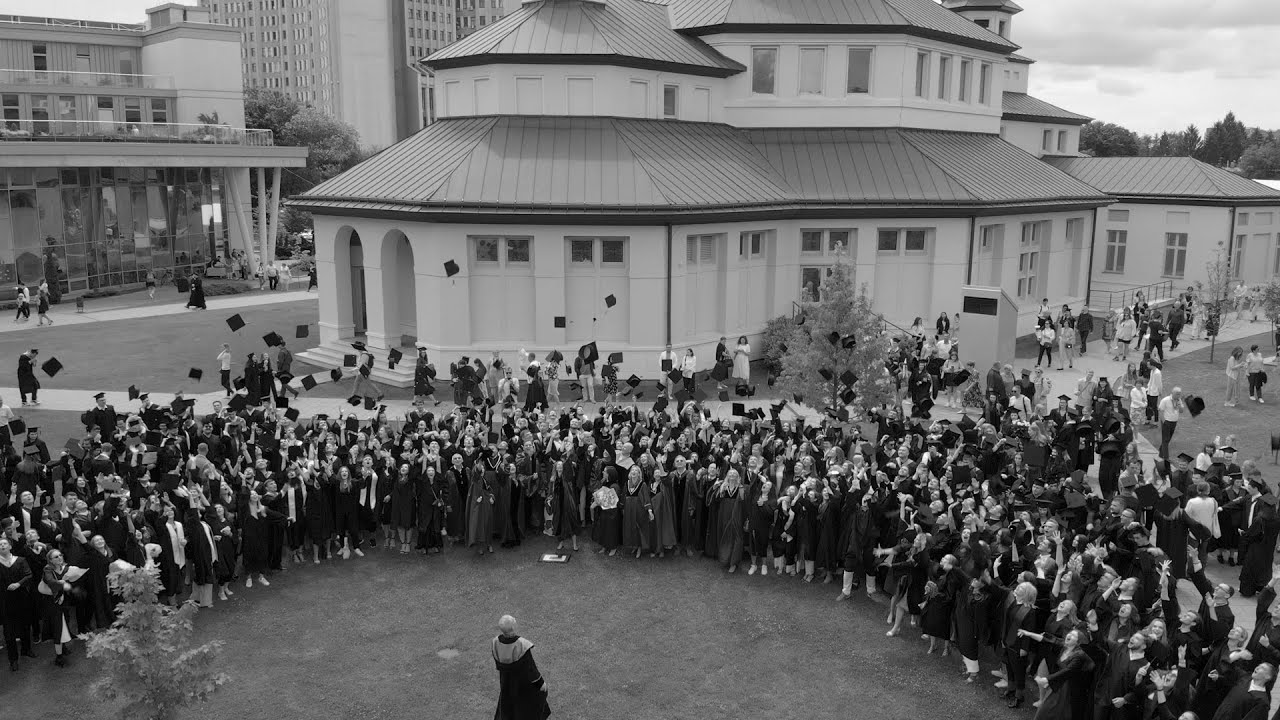

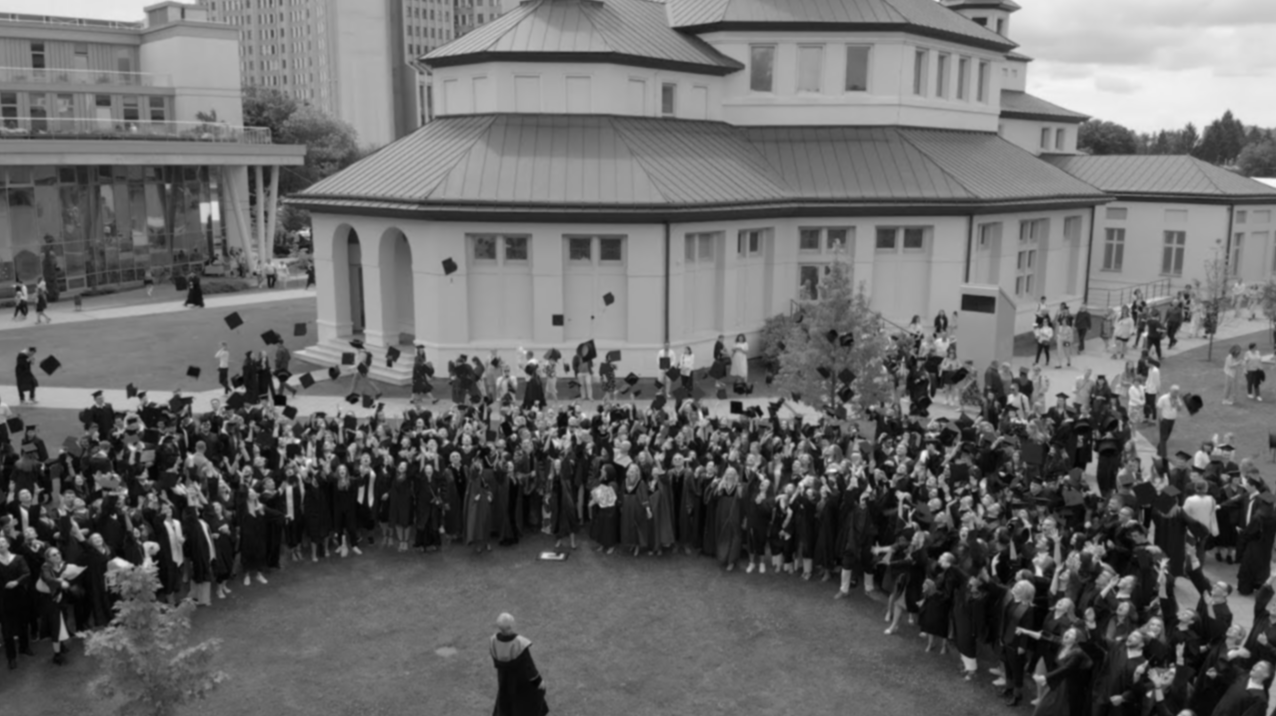

In [25]:
import time
kernel = gaussian_kernel(5, 1)
start_time = time.perf_counter()
output1 = convolve_2D(img, kernel)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
cv2_imshow(img)
cv2_imshow(output1)

In [26]:
elapsed_time

4.640955151000071

## [TODO] Optimize performance of convolution operation
Remove loops (descibe in a sentence why this improve performance)

-->  utilizing efficient array operations instead of iterating over elements, by using optimized nature of these operations in NumPy library which is written in C

Proposed solutions:

- replacing nested loops with numpy vectorization (it is written in c which allows to make the operation faster)

- so, for padding the image - np.pad

- as_strided efficiently creates windowed sub-matrices from the original array without data duplication, optimizing memory usage.

- I calculate necessary shape and strides for windowed image patches to align with the kernel, considering kernel size and image dimensions.

- np.einsum for efficient element-wise multiplication and summation in convolution


Achieves faster execution by combining memory efficiency and the speed of NumPy's array operations


In [27]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def convolve_2D_vectorized(img, kernel, padding=0, strides=1):
    if padding > 0:
        img = np.pad(img, pad_width=padding, mode='constant', constant_values=0)
    x_kernel, y_kernel = kernel.shape
    x_img, y_img = img.shape

    x_output = int(((x_img - x_kernel) / strides) + 1)
    y_output = int(((y_img - y_kernel) / strides) + 1)

    s0, s1 = img.strides
    strided_img = as_strided(img,
                             shape=(x_output, y_output, x_kernel, y_kernel),
                             strides=(s0*strides, s1*strides, s0, s1))

    output = np.einsum('ijkl,kl->ij', strided_img, kernel)
    return output


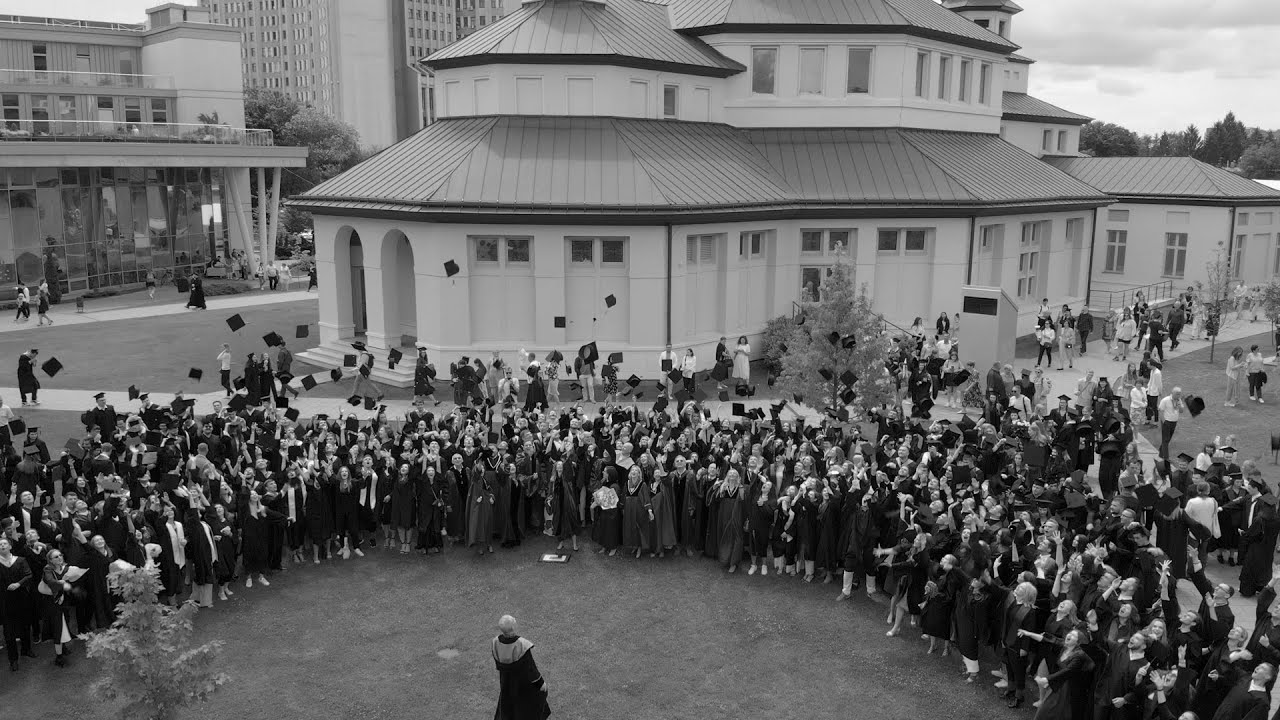

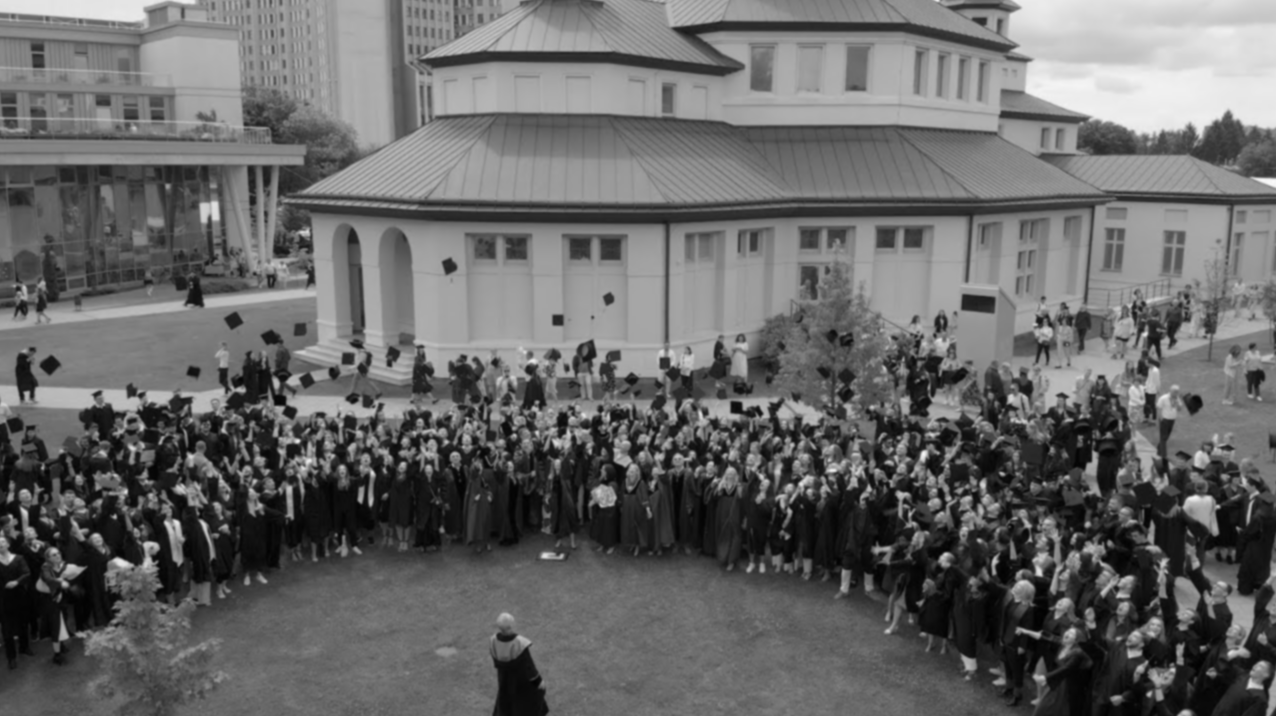

In [28]:
kernel = gaussian_kernel(5, 1)
start_time = time.perf_counter()
output2 = convolve_2D_vectorized(img, kernel)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
cv2_imshow(img)
cv2_imshow(output2)

In [29]:
elapsed_time

0.25431851500002267

## [TODO] Prove the properties of continious convolution operation
* Linearity
* Shift invariance
* Commutative
* Associative


# Commutativity

- Allows to process to-way processing (from input to output and from output to input in signal filtering, for example)


- Also, we have no need of applying filters in different orders


$x * h = h * x$

*_Proof_*:

$(f * g)(t) = (g * f)(t)$


from definition of convolution:

$(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau$

substitution: $\tau' = t - \tau$, so: $d\tau' = -d\tau$.


$= \int_{\infty}^{-\infty} f(t - \tau') g(\tau') (-d\tau')  =\int_{-\infty}^{\infty} f(t - \tau') g(\tau') d\tau' $

And by definition:

$= (g * f)(t)$

# Associativity

- Allows to process operations in any order in a series

- for example, we can combine all filters in one

$((f * g) * h)(t) = (f * (g * h))(t)$

**Proof**:


$((f * g) * h)(t) = \int_{-\infty}^{\infty} (f * g)(\tau) h(t - \tau) d\tau$

- Rewriting $ (f * g)(\tau) $:

$ = \int_{-\infty}^{\infty} \left( \int_{-\infty}^{\infty} f(\tau') g(\tau - \tau') d\tau' \right) h(t - \tau) d\tau $

- We can change the order of integration:

$ = \int_{-\infty}^{\infty} f(\tau') \left( \int_{-\infty}^{\infty} g(\tau - \tau') h(t - \tau) d\tau \right) d\tau'$

$ = \int_{-\infty}^{\infty} f(\tau') (g * h)(t - \tau') d\tau' $

 -> definition of the convolution of $f$ and $ (g * h) $:

$ = (f * (g * h))(t) $

-> Proved


# Linearity


$a(x*(h_1+h_2)) = (ax *h_1)+(ax*h_2)$

- we can run all of the processing at the same time and avoid doing this with differnt filters firstly and summing afterwards

- The linearity property of convolution states that convolution is both additive and homogeneous for any functions $f(t)$, $g(t)$, and a constant $ a $.

*_Proof_*:

1. left side of the equation :
   $a(x(t) * (h_1(t) +h_2(t))) = a \int_{-\infty}^{\infty}x(\tau)(h_1(t - \tau) + h_2(t - \tau)) d\tau$

2. $ = \int_{-\infty}^{\infty} (ax(\tau)h_1(t - \tau) +ax(\tau)h_2(t - \tau))d\tau $

   $ = \int_{-\infty}^{\infty} (ax(\tau)h_1(t - \tau)d\tau  +  \int_{-\infty}^{\infty}ax(\tau)h_2(t - \tau))d\tau $

3. $= (ax(t)) * h_1(t) + (ax(t))*h_2(t)$

So:

$a(x*(h_1+h_2)) = (ax *h_1)+(ax*h_2)$






# Shift Invariance


$(f * g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t - \tau) d\tau $

We need to show that the convolution result is the same when $ g(t) $ is shifted by $ t_0 $ or

$(f * g(t - t_0))(t) = (f * g)(t - t_0) $ -  when $ g(t) $ is shifted by $ t_0 $

*_Proof_*:

1. left side:
   $ (f * g(t - t_0))(t) = \int_{-\infty}^{\infty} f(\tau)g(t - t_0 - \tau) d\tau $

2. $ \tau' = \tau + t_0 $:

   $ = \int_{-\infty}^{\infty} f(\tau' - t_0)g(t - \tau') d\tau' $

3. This integral shifted by $ t_0 $:

   $ = (f * g)(t - t_0) $

So:

$(f * g(t - t_0))(t) = (f * g)(t - t_0) $




# Colorspace
How to change one colorspace to another?

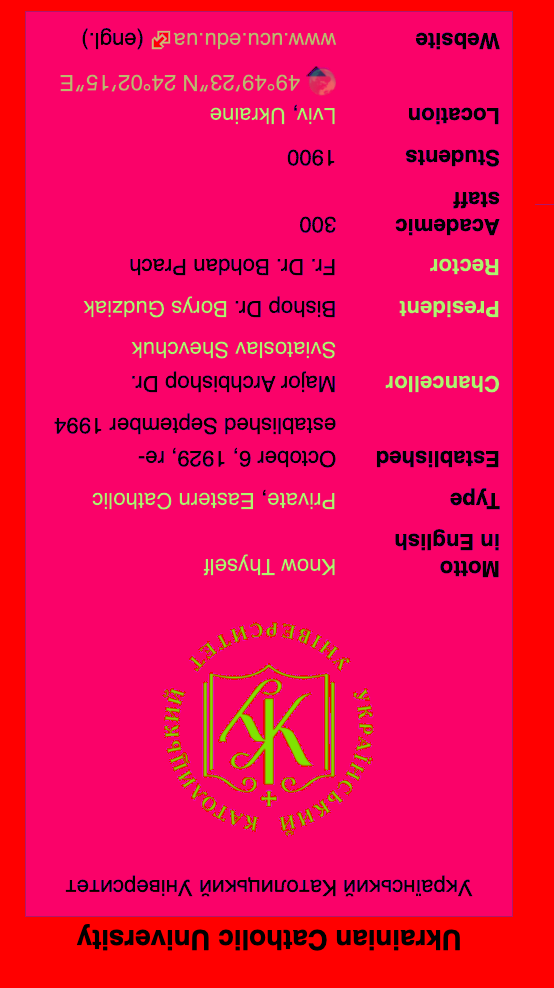

In [30]:
img = cv2.imread("wiki.png")
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
cv2_imshow(img_hsv)

Let extract logo

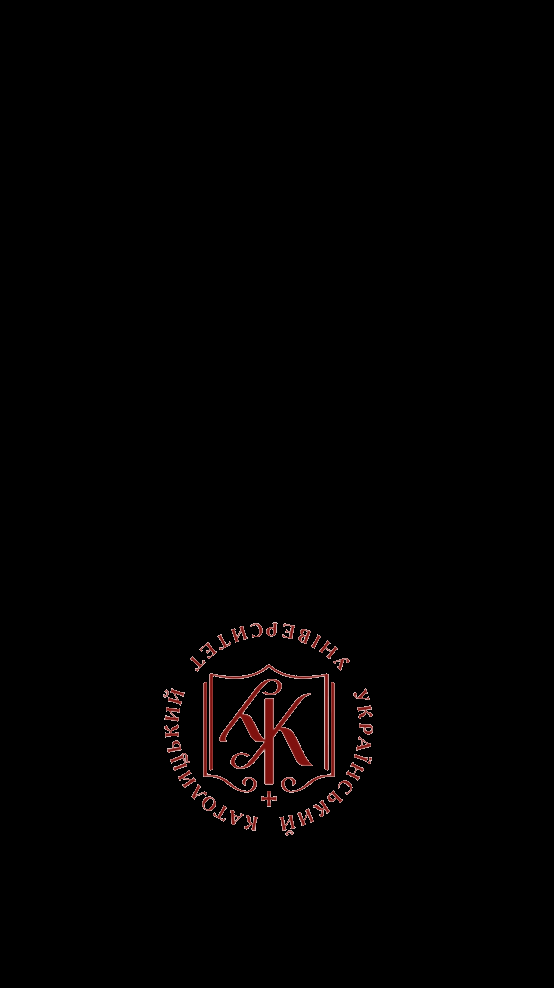

In [31]:
lower_bound = np.array([0, 20, 20])
upper_bound = np.array([5, 255, 255])
mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
img_res = cv2.bitwise_and(img, img, mask=mask)
cv2_imshow(img_res)

## [TODO] Mark green catridge in the picture (catridge.jpg)
1. Find green catridge mask
2. Overlay green catridge with by a purple mask with trasperancy. [Hint](https://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/)

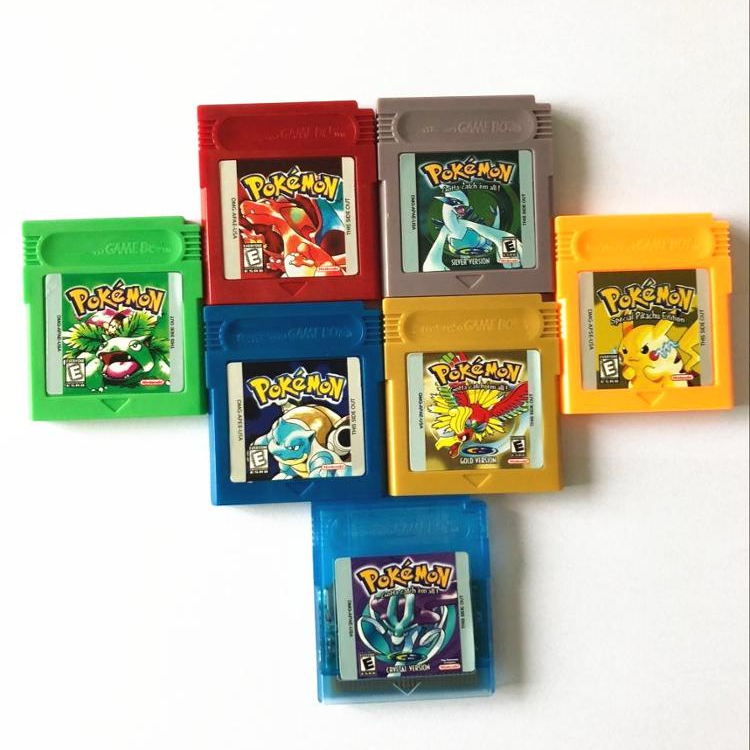

In [32]:
img = cv2.imread("catridge.jpeg")
cv2_imshow(img)

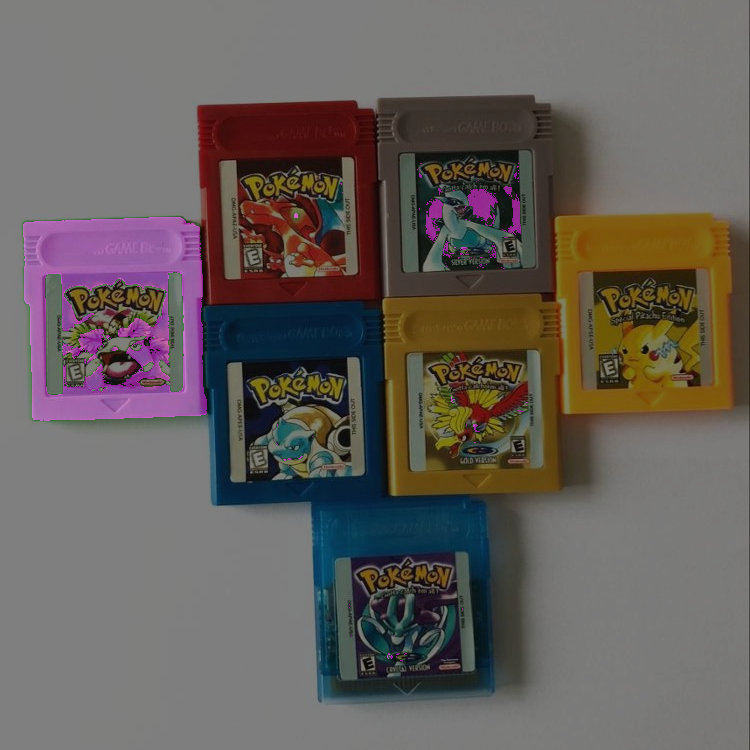

In [33]:
import cv2
import numpy as np

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
lower_green = np.array([45, 100, 50])
upper_green = np.array([75, 255, 255])
mask_green = cv2.inRange(hsv, lower_green, upper_green)
overlay = np.zeros_like(img)
overlay[:] = (255, 0, 255)
overlay = cv2.bitwise_and(overlay, overlay, mask=mask_green)
alpha = 0.5
output = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
cv2_imshow(output)

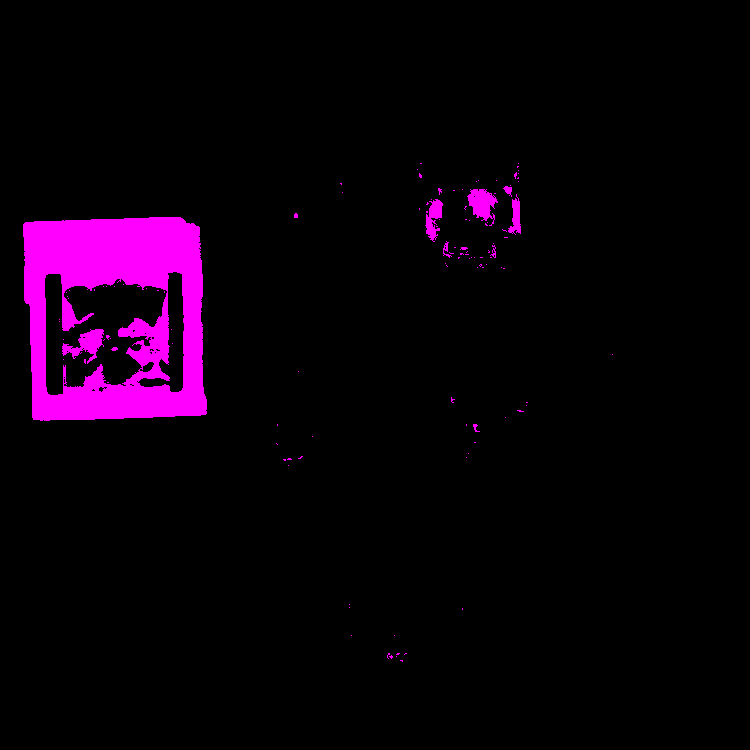

In [34]:
cv2_imshow(overlay)

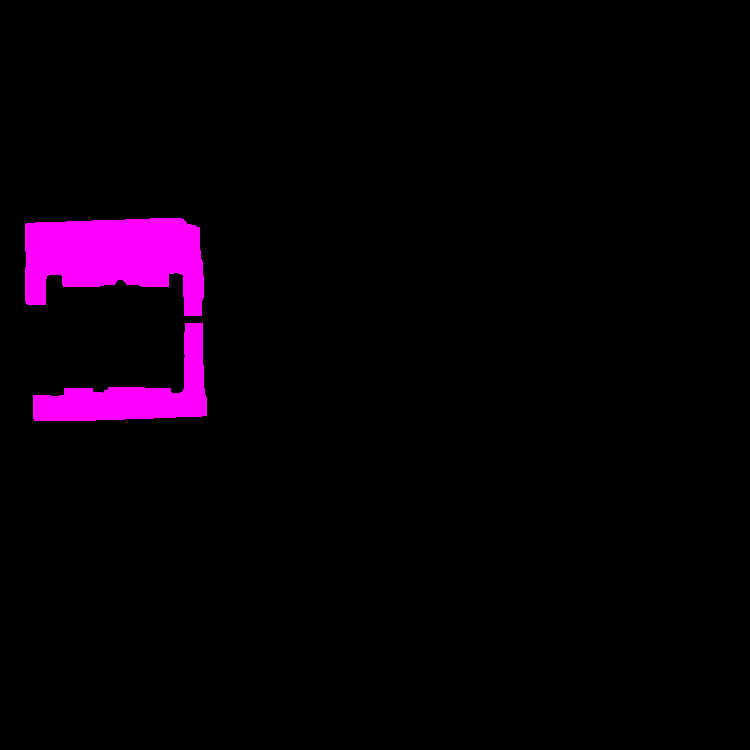

In [35]:
kernel = np.ones((18,18), np.uint8)
eroded_mask = cv2.erode(overlay, kernel, iterations=1)
clean_mask = cv2.dilate(eroded_mask, kernel, iterations=1)
cv2_imshow(clean_mask)

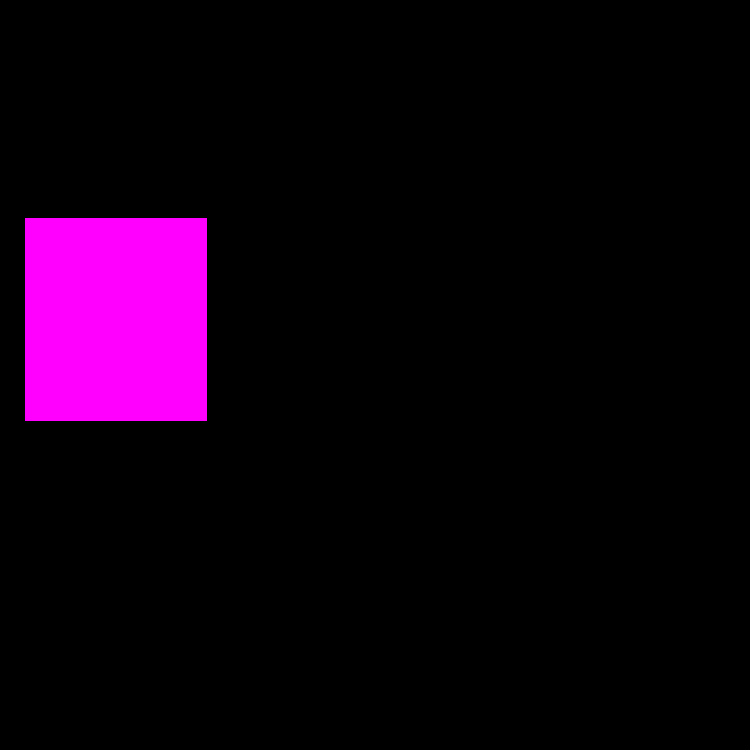

In [36]:
import cv2
import numpy as np

mask = cv2.cvtColor(clean_mask, cv2.COLOR_BGR2GRAY)
points = np.column_stack(np.where(mask.transpose() > 0))
min_x, min_y = points.min(axis=0)
max_x, max_y = points.max(axis=0)
colored_area = np.zeros_like(mask)
cv2.rectangle(colored_area, (min_x, min_y), (max_x, max_y), (255), thickness=-1)
bgr_img = cv2.cvtColor(colored_area, cv2.COLOR_GRAY2BGR)
rectangle = np.zeros_like(bgr_img)
cv2.rectangle(rectangle, (min_x, min_y), (max_x, max_y), (255, 0, 255), thickness=-1)
cv2_imshow( rectangle)


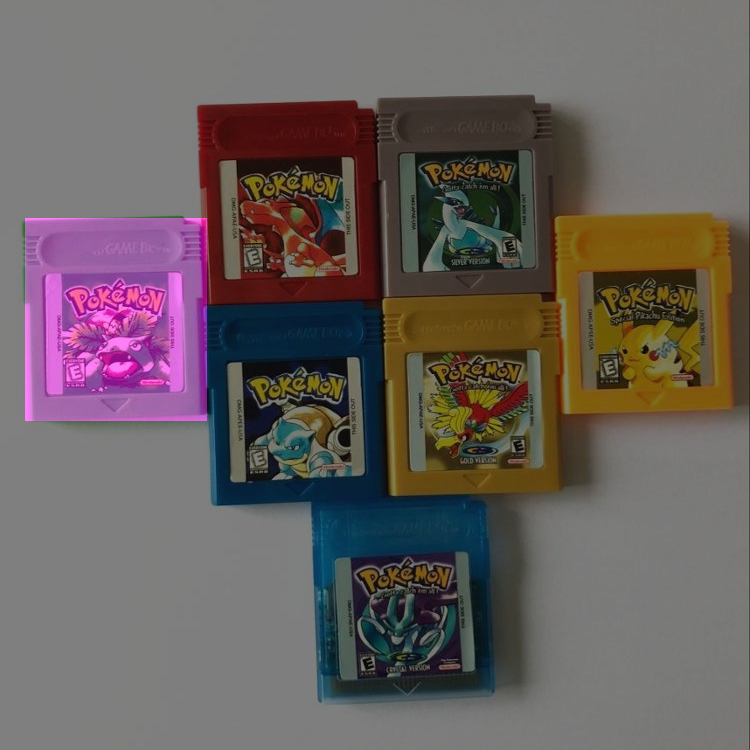

In [37]:
alpha = 0.5
output1 = cv2.addWeighted(rectangle, alpha, img, 1 - alpha, 0)
cv2_imshow(output1)

## [TODO] Identify product based on its image
How?
1. Extract text from image
2. Ask ChatGPT via API to extract the product name
3. Convert product name to embedding via ChatGPT API
4. Compare with a database of embedding extracted from Silpo product names (https://shop.silpo.ua). The database of names should include at least 300 names. You may select a specific category of product.

Show a performance of your solution based on real-life examples.  

## Reading data from file

In [ ]:
!pip install gdown

file_url = "https://drive.google.com/file/d/1-Q-QmI9Ud-3YewDVELloZKwcUwNa6rMb/view?usp=sharing"
file_id = file_url.split('/')[-2]

!gdown --id $file_id

In [39]:
import pandas as pd
json_file_path = 'silpo_shoko.json'
df = pd.read_json(json_file_path)
print(df)

                                                  name  \
0                                 Шоколад Kinder максі   
1                           Шоколад молочний Hershey's   
2                             Шоколад молочний Villars   
3                                 Шоколад чорний Wawel   
4                             Шоколад молочний E.Wedel   
..                                                 ...   
372  Шоколад молочний Millennium Fruits&Nuts мигдал...   
373  Шоколад чорний Studentska з арахісом, желейним...   
374  Шоколад чорний Cafe-Tasse з праліне мигдаль і юзу   
375  Шоколад чорний Cafe-Tasse з какао-бобами екстр...   
376  Шоколад чорний «Світоч» «Ексклюзив» з імбиром ...   

                                              imageURL  
0    https://images.silpo.ua/products/300x300/webp/...  
1    https://images.silpo.ua/products/300x300/webp/...  
2    https://images.silpo.ua/products/300x300/webp/...  
3    https://images.silpo.ua/products/300x300/webp/...  
4    https://image

In [40]:
print(df.head())

                         name  \
0        Шоколад Kinder максі   
1  Шоколад молочний Hershey's   
2    Шоколад молочний Villars   
3        Шоколад чорний Wawel   
4    Шоколад молочний E.Wedel   

                                            imageURL  
0  https://images.silpo.ua/products/300x300/webp/...  
1  https://images.silpo.ua/products/300x300/webp/...  
2  https://images.silpo.ua/products/300x300/webp/...  
3  https://images.silpo.ua/products/300x300/webp/...  
4  https://images.silpo.ua/products/300x300/webp/...  


### Adding column with extracted text with Google Vision API

In [54]:
import pandas as pd
import requests
from google.cloud import vision
from google.cloud.vision_v1 import types

def read_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.content
    else:
        raise Exception(f"Failed to fetch image from {url}")

def extract_text_from_image(image_content):
    image = types.Image(content=image_content)
    response = client.text_detection(image=image)
    texts = response.text_annotations
    return texts[0].description if texts else ""

extracted_texts = []

for _, row in df.iterrows():
    try:
        image_url = row['imageURL']
        image_content = read_image_from_url(image_url)
        extracted_text = extract_text_from_image(image_content)
        extracted_text = str(extracted_text).replace('\n', '')
    except Exception as e:
        extracted_text = str(e)

    extracted_texts.append(extracted_text)

df['extracted_text'] = extracted_texts

df.to_csv("output_with_extracted_texts.csv", index=False)


In [55]:
df.head()

name  \
0        Шоколад Kinder максі   
1  Шоколад молочний Hershey's   
2    Шоколад молочний Villars   
3        Шоколад чорний Wawel   
4    Шоколад молочний E.Wedel   

                                            imageURL  \
0  https://images.silpo.ua/products/300x300/webp/...   
1  https://images.silpo.ua/products/300x300/webp/...   
2  https://images.silpo.ua/products/300x300/webp/...   
3  https://images.silpo.ua/products/300x300/webp/...   
4  https://images.silpo.ua/products/300x300/webp/...   

                                      extracted_text  
0                           Kinder Maxi+молоко-какао  
1                            HERSHEY'Smilk chocolate  
2  deCVILLARSPO CHSEDLAT SUISSECOLLECTION PURELAI...  
3  Wawelsince 1898DARK 70% CocoaNET MT-3.17:02 (9...  
4  VOLOLASSIO MILK SHOGOLATEWedelMILK CLASSICWILK...

In [56]:
print(len(df))

377


In [ ]:
api_key = "input_api_key"

### Get image by url

In [72]:
import cv2
import numpy as np
import requests

def read_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        return cv2.imdecode(image_array, -1)
    else:
        raise Exception(f"Failed to fetch image from {url}")


In [79]:
i = 3
row = df.loc[i]
row

name                                           Шоколад чорний Wawel
imageURL          https://images.silpo.ua/products/300x300/webp/...
extracted_text    Wawelsince 1898DARK 70% CocoaNET MT-3.17:02 (9...
Name: 3, dtype: object

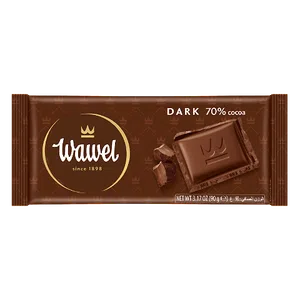

In [117]:
url = row['imageURL']
image = read_image_from_url(url)
cv2_imshow(image)

### Get name of the product with OpenAI API analyzing the text given by Google Vision API

In [115]:
import requests
import json

def get_content(text):
  url = 'https://api.openai.com/v1/chat/completions'

  headers = {
      'Content-Type': 'application/json',
      'Authorization': f'Bearer {api_key}'
  }

  data = {
      "model": "gpt-3.5-turbo-0301",
      "messages": [{"role": "user", "content": f"get the name of the product from text: {text} and return only this name"}]
  }

  response = requests.post(url, headers=headers, data=json.dumps(data))
  content = response.json()['choices'][0]['message']['content']
  return content

### Get embeddings for real product name and give from *_openai_* after analysing *_vision_api_* text

In [111]:
import requests
import json
def get_embedding(text):
  url = 'https://api.openai.com/v1/embeddings'
  headers = {
      'Content-Type': 'application/json',
      'Authorization': f'Bearer {api_key}'
  }
  data = {
      "input": text,
      "model": "text-embedding-ada-002"
  }
  response = requests.post(url, headers=headers, data=json.dumps(data))
  embeddings = response.json()['data'][0]['embedding']
  return embeddings

In [121]:
embeddings1 = get_embedding(get_content(row['extracted_text']))
embeddings2 = get_embedding(row['name'])

### analyzing embeddings to get similarity

In [122]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity([embeddings1], [embeddings2])[0][0]

In [123]:
similarity

0.8721109347993117

### In this case similarity is quite high

let's check for others:

In [124]:
list_of_accuracies = []

for i in range(20):
  row = df.loc[i]
  embeddings1 = get_embedding(get_content(row['extracted_text']))
  embeddings2 = get_embedding(row['name'])
  similarity = cosine_similarity([embeddings1], [embeddings2])[0][0]
  list_of_accuracies.append(similarity)

In [125]:
for element in list_of_accuracies:
  print(element)

0.8415290156069648
0.8928471290483371
0.7687286541211198
0.8719008191114717
0.7789189439536633
0.8664066983960591
0.79541052145148
0.8805706150710181
0.8420918319447862
0.8005078712061322
0.8447722500063317
0.8651307837021673
0.7817939708700323
0.8859544327597646
0.8861907565399568
0.8010364671482026
0.8649626778883819
0.8312421269967452
0.867639827960482
0.7318470091094469


In [126]:
mean = sum(list_of_accuracies) / len(list_of_accuracies)
print("Mean:", mean)

Mean: 0.8349741201446271
